## Final Project Submission

You'll clean, explore, and model this dataset with a multivariate linear regression to predict the sale price of houses as accurately as possible.

Please fill out:
* Student name: Caitlin Snyder
* Student pace: self-paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL: 



# 1) Introduction

As I wrap up Module 3 of Flat Iron's Data Science bootcamp, I will be 

...

Follow along below, or take a look at the [Jupyter notebook]().

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/


I'll try to answer these questions below--let's get started!

# 2) Define the relevant classes

I'll be taking an object-oriented approach to this project and will begin by defining the classes and constants I'll need.

## A) Accessing the data

### Paths
We'll define our path strings within a simple dictionary for easy loading:


In [49]:
paths = {
        'train_values': 'data/training_set_values.csv',
        'train_labels': 'data/training_set_labels.csv',
        'test_values': 'data/test_set_values.csv'
}       

### Data Loader
The Data Loader will load the appropriate csvs. This helper class includes an option (run_type_dev) to downsample our dataset as needed:

In [50]:
import pandas as pd
import numpy as np

class DataLoader:
    def __init__(self):
        pass

    def load(self, outcome, run_type_dev, sample_size):
        X_train = self.load_from_path(paths['train_values'])
        y_train = self.load_from_path(paths['train_labels'])
        
        if run_type_dev:
            print(f"Sample size = {sample_size}")
            X_train = X_train.iloc[0:sample_size]
            y_train = y_train.iloc[0:sample_size]
            
        df = pd.concat([X_train, y_train], axis=1, join="inner")
        self.outcome_values = np.unique(df[outcome])
        return df
    
    def load_from_path(self, path):
        df = pd.read_csv(path)
        df.set_index('id', inplace=True)
        return df
        

## B) Cleaning the data

### Fuzzy Matcher
Columns 'funder' and 'installer' include many similar values with slightly different spellings (ie, 'unicef' and 'unicf'). We'll use the Fuzzy Matcher class to consolidate these values using the fuzzy-wuzzy library:

In [51]:
import numpy as np
import pandas as pd

from fuzzywuzzy import fuzz
from fuzzywuzzy import process


class FuzzyMatcher:
    def __init__(self):
        self.cols = []
    
    def set_fuzzy_matches(self, df, cols):
        self.cols = cols
        self.clean_col_text(df)
        
        scores_df = self.get_matches(df)       
        self.replace_with_matches(df, scores_df) 
        
    def clean_col_text(self, df):
        for col in self.cols:
            df[col] = df[col].str.lower()
            df[col] = df.apply(lambda row: self.manually_clean_col_text(str(row[col])), axis=1)
            df[col] = df.apply(lambda row: self.remove_special_chars(str(row[col])), axis=1)
            
    def manually_clean_col_text(self, value):
        replace_dict = { # ideally in constants file
            "private individual": "private",
            "not known": "unknown",
            "0": "unknown",
            "-": "unknown",
            "nan": "unknown",
            "action in a": "action in africa",
            "wateraid": "water aid"
        }
        if value in replace_dict.keys():
            value = replace_dict[value]
        return value
    
    def remove_special_chars(self, value):
        special_chars = [".", "/", "-", "[", "]", "(", ")"]
        for char in special_chars:
            value = value.replace(char, "")
        return value
    
    def get_matches(self, df):
        values = self.get_values(df)
        match_df = self.get_match_df(values)
        scores_df = self.get_scores(match_df)
        return scores_df

    def get_values(self, df):
        list_of_lists = [df[col] for col in self.cols]
        values = [j for sub in list_of_lists for j in sub]
        return np.unique([str(i).lower() for i in values if str(i) != 'nan']).tolist()
    
    def get_match_df(self, values):
        score_sort = [(x,) + i
                     for x in values 
                     for i in process.extract(x, values, scorer=fuzz.token_sort_ratio)]
        match_df = pd.DataFrame(score_sort, columns=['name_sort','match_sort','score_sort'])
        match_df['sorted_name_sort'] = \
            np.minimum(match_df['name_sort'], match_df['match_sort'])
        return match_df
    
    def get_scores(self, match_df):
        high_score_sort = self.get_score_sort(match_df)
        scores = self.get_score_groups(high_score_sort)
        scores_df = self.get_score_frame(scores)
        return scores_df

    def get_score_sort(self, match_df):
        high_score_sort = \
            match_df.loc[(match_df['score_sort'] >= 80) &
                    (match_df['name_sort'] !=  match_df['match_sort']) &
                    (match_df['sorted_name_sort'] != match_df['match_sort'])]
        
        high_score_sort = high_score_sort.drop('sorted_name_sort', axis=1).copy()
        return high_score_sort
        

    def get_score_groups(self, high_score_sort):
        return high_score_sort.groupby(['name_sort','score_sort']).agg(
                        {'match_sort': ', '.join}).sort_values(
                        ['score_sort'], ascending=False)
        
    def get_score_frame(self, scores):
        frame = { 
            'name_sort': scores.index.get_level_values(0), 
            'score_sort': scores.index.get_level_values(1),
            'match_sort': list(map(lambda x: x[0], scores.values.tolist())),
        }
        return pd.DataFrame(frame)
    
    def replace_with_matches(self, df, df_matches):
        for col in self.cols:
            for name in df_matches["name_sort"]:
                if name in df[col].values.tolist():
                    replace_value = df_matches.loc[df_matches["name_sort"] == name,
                                                   "match_sort"].values.tolist()[0]
                    df[col].replace(name, replace_value, inplace=True)



### VizHelper
The Viz Helper will output relevant visualizations to inform iterative cleaning and analysis:

In [52]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class VizHelper:
    def __init__(self):
        pass

    def show_visualizations(self, df, outcome):
        cont_features = df.select_dtypes(exclude=['object']).columns
        self.generate_heat_map(df, cont_features)
        self.show_outliers(df, cont_features)
        self.show_basic_correlations(df, cont_features, outcome)
        self.show_outcome_dist(df, outcome)

    def generate_heat_map(self, df, features):
        plt.figure(figsize=(7, 6))
        sns.heatmap(df[features].corr(), center=0)
        plt.show()

    def show_outliers(self, df, cols):
        fig, axes = plt.subplots(2, 3, figsize=(9, 6))
        axe = axes.ravel()

        for i, xcol in enumerate(cols):
            sns.boxplot(x=df[xcol], ax=axe[i])
        plt.show()

    def show_basic_correlations(self, df, cols, outcome):
        preds = [i for i in cols if i != outcome]
        fig, axes = plt.subplots(2, 3, figsize=(9, 6))
        axe = axes.ravel()

        for i, xcol in enumerate(preds):
            df.plot(kind='scatter', x=xcol, y=outcome, alpha=0.4, color='b', ax=axe[i])
        
        plt.show()

    def show_outcome_dist(self, df, outcome):
        df[outcome].value_counts().plot(kind='bar')

    def show_confusion_matrix(self, clf, X_test, y_test, outcome, title):
        labels = y_test[outcome].unique()
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                        display_labels=labels,
                                        cmap=plt.cm.Greens,
                                        xticks_rotation='vertical')
        disp.ax_.set_title(title)
        plt.show()


### Cleaner
Our Cleaner will call the Fuzzy Matcher class as well as perform some basic cleaning tasks (eliminate impossible 0 values, correct column data types) on our raw data:

In [53]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

class Cleaner():
    def __init__(self):
        self.viz_helper = VizHelper()

    def clean_df(self, df):
        df.drop(['num_private', 'amount_tsh'], axis=1, inplace=True)
        self.convert_to_string(df)
        self.replace_nan(df)
        FuzzyMatcher().set_fuzzy_matches(df, ['funder', 'installer'])
        return df
    def convert_to_string(self, df):
        cols = [
            'region_code', 
            'district_code', 
            'public_meeting', 
            'permit'
        ]
        list(map(lambda col: self.change_type(df, col, str), cols))
    
    def change_type(self, df, col, new_type):
        df[col] = df[col].astype(new_type)

    def replace_nan(self, df):
        self.replace_null_strings(df, "nan")
        self.replace_null_strings(df, "none")
        self.replace_zeros(df, "longitude")
        self.replace_zeros(df, "latitude")
        self.replace_zeros(df, 'construction_year')
        self.replace_zeros(df, 'population')

    def replace_null_strings(self, df, null_str):
        df.replace(to_replace=null_str, value="unknown", inplace=True)

    def replace_zeros(self, df, col):
        df[col] = df.apply(lambda row: np.nan 
            if row[col] == 0 else row[col], axis=1)

## C) Build the pipeline

### Splits Manager
The Splits Manager will allow us to easily access our train-test datasets (without worrying about the typos that a simple dictionary access command is susceptible to): 

In [54]:
class SplitsManager:
    def __init__(self):
        self.X_train = None
        self.X_test = None, 
        self.y_train = None 
        self.y_test = None
        

### Pre-Processor
The Pre-Processor defines transformations our pipeline will use. Since our dataset is unbalanced (a histogram of our outcome variable shows that 'functional' is vastly over-represented in the dataset relative to the other two outcomes), we will oversample our minority outcomes to achieve a more balanced dataset.

In [55]:
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

class PreProcessor():
    def __init__(self):
        pass

    def get_preprocessor(self, df):
        return {
            'sampler': self.get_resampler(),
            'col': self.get_col_transformer(df)
            }

    def get_resampler(self):
        return RandomOverSampler(random_state=42)
        
    def get_col_transformer(self, df):
        cont_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())])

        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

        return ColumnTransformer(
            transformers=[
                ('num', cont_transformer, self.get_cont_features(df)),
                ('cat', cat_transformer, self.get_cat_features(df))])

    def get_cat_features(self, df):
        return df.select_dtypes(include=['object']).columns
        
    def get_cont_features(self, df):
       return df.select_dtypes(exclude=['object']).columns
    
        

### Classifiers
We can store our classifiers in a dictionary so that we can easily iterate over them during analysis:


In [56]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

classifiers = {
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'svm': SVC(),
    'knn': KNeighborsClassifier(),
}

### Param Grids
We can similarly store the corresponding param grid for each classifier in a dictionary:


In [57]:
import numpy as np

param_grids = {
    'decision_tree': {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 2, 3, 4, 5, 6],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4, 5, 6]
    },
    'random_forest': {
        'clf__n_estimators': [10, 20, 30],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [5, 10, 20, 30, 35],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [2, 3, 6]
    },
    'svm': {
        'clf__C': [0.1, 1, 10, 100, 1000], 
        'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'clf__kernel': ['rbf']
    },
    'knn': {
        'clf__n_neighbors': [3, 5, 7, 11, 19],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    }
}

### Report Manager
The Report Manager will use the shared keys in these two dictionaries to iterate over each classifier and score its performance:


In [58]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline as imbPipeline

class ReportManager:
    def __init__(self, outcome):
        self.splits = None
        self.outcome = outcome
        self.results = []
        
    def run_reports(self, preprocessor, splits: SplitsManager):
        self.splits = splits
        list(map(lambda key: self.execute_pipeline(preprocessor, key), classifiers.keys()))
        list(map(lambda x: self.display_predictions(x), self.results))
        self.display_results()

    def execute_pipeline(self, preprocessor, key):
        print(f"Beginning {key}...")
        param_grid = param_grids[key]
        param_grid['col__num__imputer__strategy'] = ['mean', 'median']

        pipe = imbPipeline([
            ('col', preprocessor['col']),
            ('sampler', preprocessor['sampler']),
            ("clf", classifiers[key])
            ])
        gs = GridSearchCV(pipe,
                            param_grid,
                            cv=3,
                            scoring="accuracy"
                        )
        gs_results  = gs.fit(self.splits.X_train, self.splits.y_train.values.ravel())
        self.results.append(ResultsManager(key, gs_results))

    def display_results(self):
        rows = list(map(lambda x: [x.clf_name, x.best_score, x.best_params], self.results))
        df = pd.DataFrame(rows, columns=[
            'clf_name', 
            'best_score', 
            'best_params'
        ]).sort_values(by='best_score', ascending = False)
        print(df)
        print('---------\nAccuracy reports\n---------')
        for result in self.results:
            print(f"{result.clf_name}: {result.best_score:.2%}")

    def display_predictions(self, result: ResultsManager):
        title = f"{result.clf_name} ({result.best_score:.2%})"
        VizHelper().show_confusion_matrix(result.best_estimator, self.splits.X_test, self.splits.y_test, self.outcome, title)


## D) Tying it all together

### Data Manager
The Data Manager is responsible for coordinating the different helper classes responsible for cleaning, pipeline-creation, visualization, and analysis:

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts

class DataManager:
    def __init__(self, sample_size, run_type_dev=True):
        self.sample_size = sample_size
        self.outcome = 'status_group'
        self.splits = SplitsManager()
        self.process_data(run_type_dev,)

    def process_data(self, run_type_dev):
        raw_df = DataLoader().load(self.outcome, run_type_dev, self.sample_size)
        df = Cleaner().clean_df(raw_df)
        VizHelper().show_visualizations(df, self.outcome)
        self.set_splits(df, self.outcome)
   
    def set_splits(self, df, outcome):
        X = df[[i for i in df.columns if i != outcome]]
        y = df[[outcome]]
        
        self.splits.X_train, self.splits.X_test,\
            self.splits.y_train, self.splits.y_test =\
            tts(X, y, test_size = 0.2, random_state = 42)
            
    def get_report(self):
        preprocessor = PreProcessor().get_preprocessor(self.splits.X_train)
        ReportManager(self.outcome).run_reports(preprocessor, self.splits)


# 3) Analyze

Now that we've defined our classes, we can kick off the analysis:

Sample size = 5000


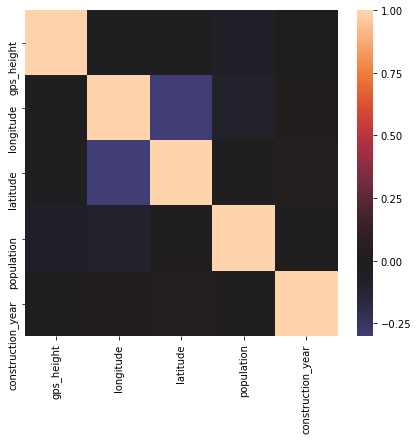

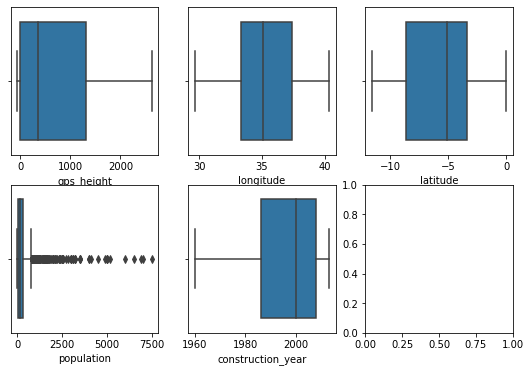

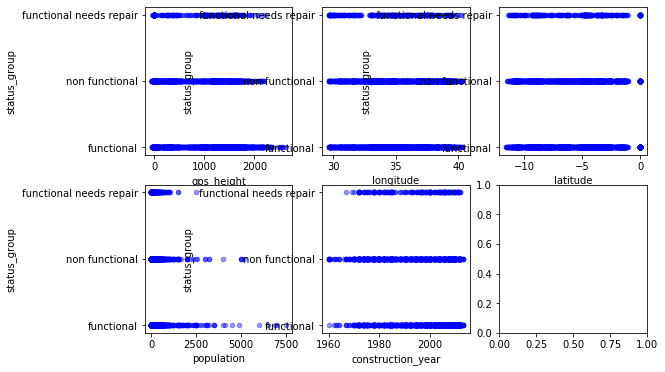

Beginning decision_tree...
Beginning random_forest...
Beginning svm...
Beginning knn...


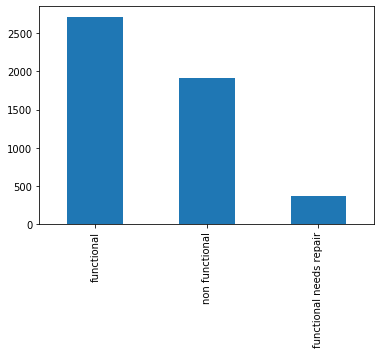

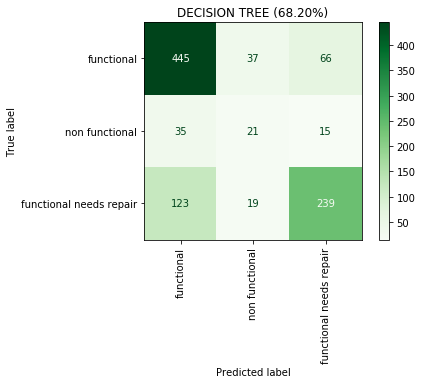

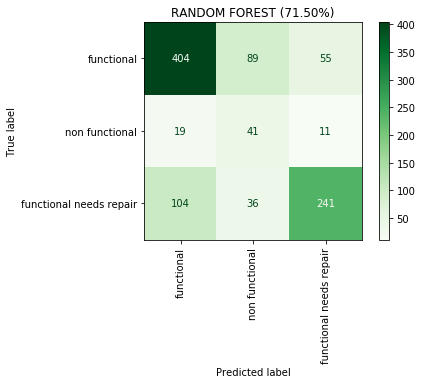

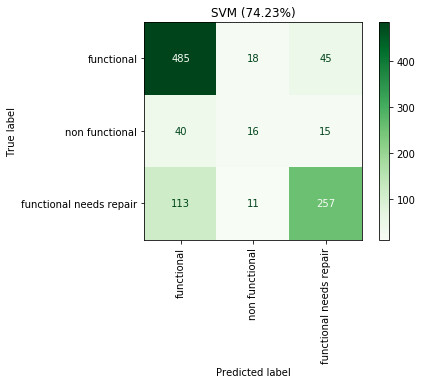

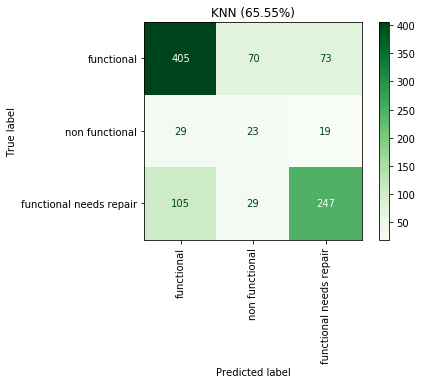

        clf_name  best_score  \
2            SVM    0.742250   
1  RANDOM FOREST    0.714999   
0  DECISION TREE    0.682005   
3            KNN    0.655498   

                                         best_params  
2  {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel...  
1  {'clf__criterion': 'entropy', 'clf__max_depth'...  
0  {'clf__criterion': 'gini', 'clf__max_depth': N...  
3  {'clf__metric': 'manhattan', 'clf__n_neighbors...  
---------
Accuracy reports
---------
DECISION TREE: 68.20%
RANDOM FOREST: 71.50%
SVM: 74.23%
KNN: 65.55%


In [60]:
dfs = DataManager(sample_size=5000, run_type_dev=True)
dfs.get_report()

# 4) Results & Take-aways

Reviewing both the classifier score readings and the confusion matrices outputted by our ReportManager class, we can see that the Random Forest Classifier has performed best (with an accuracy score of ).

Additional areas for exploration might include elevation and water-resource conflict incidences.

### Sources



- https://towardsdatascience.com/fuzzywuzzy-find-similar-strings-within-one-column-in-a-pandas-data-frame-99f6c2a0c212
    
- https://towardsdatascience.com/fuzzywuzzy-fuzzy-string-matching-in-python-beginners-guide-9adc0edf4b35

- https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
    
- https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/

- https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

- https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

- https://datascience.stackexchange.com/questions/60862/if-i-have-negative-and-positive-numbers-for-a-feature-should-minmaxscaler-be-1

- https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline

- https://lifewithdata.com/2021/04/02/how-to-build-machine-learning-pipeline-with-scikit-learn-and-why-is-it-essential/

- https://stackoverflow.com/questions/63467815/how-to-access-columntransformer-elements-in-gridsearchcv

- https://openscoring.io/blog/2020/10/24/converting_sklearn_imblearn_pipeline_pmml/

- https://imbalanced-learn.org/stable/over_sampling.html

- https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3